In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import os
import sys

module_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from maze_env import MazeEnv
from maze import Maze
from maze_env import dist_to_wall_exact
from maze_env import compute_dead_end_mask
from maze_env import compute_horizontal_corridor_mask
from maze_env import compute_degree_matrix

# Initialization of env.
maze = Maze(10, 10, 0, 0) 
env = MazeEnv(sz=10, maze=None, start=np.array([0.05, 0.05]), goal=np.array([0.95, 0.95]),
               reward="distance", log=False, eval=False, dt=0.1, horizon=100, 
               wall_penalty=10, slide=1, image_freq=100)

dead_mask = compute_dead_end_mask(
    env.maze, 
    exits={(
        int(env.goal[0]*env.sz), 
        int(env.goal[1]*env.sz)
        )})

corr_mask = compute_horizontal_corridor_mask(env.maze)

deg_mat = compute_degree_matrix(env.maze)

# Function to generate valid points into the maze 
# def generate_positions(env, num_samples=500, max_attempts=5000):
#     positions = set()
#     attempts = 0
    
#     while len(positions) < num_samples and attempts < max_attempts:
#         state = env.sample_open_state_continuous()
        
#         # If the point lies on a wall, try again 
#         if not env.point_collision(state[0], state[1]):
#             positions.add(tuple(state))
        
#         attempts += 1
    
#     if len(positions) < num_samples:
#         print(f"Warning: Only {len(positions)} unique positions generated out of {num_samples} requested.")
    
#     return np.array(list(positions))

def generate_positions_balanced(env, num_samples=5000, target_ratio=0.5):
    """
    target_ratio = frazione desiderata di punti con degree>0
    """
    points_zero, points_nonzero = [], []
    # rigenera finché non hai il mix desiderato
    while len(points_zero) + len(points_nonzero) < num_samples:
        s = env.sample_open_state_continuous()
        # deg = corridor_degree(env, *s)              # la nuova funzione
        deg = corridor_degree_continuous(env, *s)
        (points_nonzero if deg > 0 else points_zero).append(tuple(s))
        # stop se abbiamo raggiunto il rapporto
        nz_needed = int(num_samples * target_ratio)
        z_needed  = num_samples - nz_needed
        if len(points_nonzero) >= nz_needed and len(points_zero) >= z_needed:
            break
    # ritaglia e mescola
    points = points_nonzero[:nz_needed] + points_zero[:z_needed]
    random.shuffle(points)
    return np.array(points, dtype=float)

# Extended dead-end detection function
def is_dead_end_extended(env, x, y, radius=2):
    cx, cy = int(x * env.sz), int(y * env.sz)
    blocked_directions = 0
    
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            nx, ny = cx + dx, cy + dy
            if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
                blocked_directions += 1
            else:
                cell = env.maze.cell_at(nx, ny)
                if all(cell.walls.values()):
                    blocked_directions += 1
    
    return blocked_directions >= (radius * radius // 2)

# def is_dead_end_bfs(env, x, y):
#     from collections import deque

#     # Coordinate di griglia
#     cx, cy = int(x * env.sz), int(y * env.sz)

#     # Se la cella di partenza è completamente chiusa, è triviale
#     if all(env.maze.cell_at(cx, cy).walls.values()):
#         return True

#     nx, ny = env.maze.nx, env.maze.ny
#     visited = set()
#     queue = deque()
#     queue.append((cx, cy))
#     visited.add((cx, cy))

#     while queue:
#         cx, cy = queue.popleft()

#         # Se siamo su un cella di bordo, NON è dead end
#         # (oppure potresti controllare se ci sono muri aperti sul bordo, dipende dalla definizione).
#         if cx == 0 or cy == 0 or cx == nx-1 or cy == ny-1:
#             return False

#         # Controllo celle adiacenti (N, S, E, W) in base ai muri
#         cell = env.maze.cell_at(cx, cy)
#         if not cell.walls["N"] and (cx, cy-1) not in visited:
#             visited.add((cx, cy-1))
#             queue.append((cx, cy-1))
#         if not cell.walls["S"] and (cx, cy+1) not in visited:
#             visited.add((cx, cy+1))
#             queue.append((cx, cy+1))
#         if not cell.walls["W"] and (cx-1, cy) not in visited:
#             visited.add((cx-1, cy))
#             queue.append((cx-1, cy))
#         if not cell.walls["E"] and (cx+1, cy) not in visited:
#             visited.add((cx+1, cy))
#             queue.append((cx+1, cy))

#     # Se esauriamo tutte le celle esplorabili senza mai raggiungere il bordo, è un dead-end
#     return True


import numpy as np
from scipy.spatial import distance
from queue import PriorityQueue

def can_move(env, cx, cy, nx, ny):
    """
    Verifica se è possibile muoversi dalla cella (cx,cy) alla cella (nx,ny)
    controllando sia i limiti che i muri parziali.
    """
    # Se la cella di destinazione è fuori indice o completamente chiusa, non si può entrare
    if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
        return False
    if all(env.maze.cell_at(nx, ny).walls.values()):
        return False
    
    # Controlliamo i muri fra cella corrente e cella destinazione
    current_cell = env.maze.cell_at(cx, cy)
    next_cell    = env.maze.cell_at(nx, ny)
    dx = nx - cx
    dy = ny - cy

    # Muoversi a nord => dy=-1
    if dx == 0 and dy == -1:
        if current_cell.walls["N"] or next_cell.walls["S"]:
            return False
    # Muoversi a sud => dy=+1
    elif dx == 0 and dy == 1:
        if current_cell.walls["S"] or next_cell.walls["N"]:
            return False
    # Muoversi a est => dx=+1
    elif dx == 1 and dy == 0:
        if current_cell.walls["E"] or next_cell.walls["W"]:
            return False
    # Muoversi a ovest => dx=-1
    elif dx == -1 and dy == 0:
        if current_cell.walls["W"] or next_cell.walls["E"]:
            return False

    return True


def shortest_path_distance(env, x, y):
    """
    Esegue una ricerca di cammino minimo (tipo A*) dal punto (x,y) continuo 
    (in [0,1]^2) alla cella che contiene il goal env.goal,
    restituendo il costo (in celle attraversate) oppure np.inf se non esiste un percorso.
    """
    # Convertiamo le coordinate da [0..1] a celle
    cx, cy = int(x * env.sz), int(y * env.sz)
    goal_x, goal_y = int(env.goal[0] * env.sz), int(env.goal[1] * env.sz)
    
    frontier = PriorityQueue()
    frontier.put((0, (cx, cy)))         # coda prioritaria (costo stimato, (cx,cy))
    cost_so_far = {(cx, cy): 0}         # dizionario dei costi finora noti

    while not frontier.empty():
        _, current = frontier.get()     # estrai la cella con priorità minore
        if current == (goal_x, goal_y):
            # Abbiamo trovato il goal
            break

        current_cost = cost_so_far[current]
        
        # Proviamo tutte le direzioni (N, S, E, W)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = current[0] + dx, current[1] + dy
            
            # Verifica i muri
            if not can_move(env, current[0], current[1], nx, ny):
                continue
            
            new_cost = current_cost + 1
            # Se non abbiamo mai visitato next_pos o se abbiamo trovato un costo minore, aggiorna
            if (nx, ny) not in cost_so_far or new_cost < cost_so_far[(nx, ny)]:
                cost_so_far[(nx, ny)] = new_cost
                # euristica: distanza euclidea dalla destinazione
                priority = new_cost + distance.euclidean((nx, ny), (goal_x, goal_y))
                frontier.put((priority, (nx, ny)))
    
    # Se non è stato trovato un percorso, restituisce np.inf
    return cost_so_far.get((goal_x, goal_y), np.inf)


def is_dead_end(env, x, y, dead_mask):
    cx = min(int(x * env.sz), env.maze.nx - 1)
    cy = min(int(y * env.sz), env.maze.ny - 1)
    return dead_mask[cy, cx]

def in_horizontal_corridor(env, x, y, corr_mask):
    cx = min(int(x * env.sz), env.maze.nx-1)
    cy = min(int(y * env.sz), env.maze.ny-1)
    return bool(corr_mask[cy, cx])

def cell_degree(env, x, y, deg_mat):
    cx = min(int(x*env.sz), env.maze.nx-1)
    cy = min(int(y*env.sz), env.maze.ny-1)
    return int(deg_mat[cy, cx])

# def corridor_degree(env, x, y):
#     goal_cx = int(env.goal[0] * env.sz)
#     goal_cy = int(env.goal[1] * env.sz)

#     cx = min(int(x * env.sz), env.maze.nx - 1)
#     cy = min(int(y * env.sz), env.maze.ny - 1)

#     if cx == goal_cx and cy == goal_cy:
#         return 1.0

#     step_size = 3 # Assumendo step=3 da make_maze_fail

#     group_from_top = cy // step_size
#     in_group       = cy % step_size

#     v_min = group_from_top * 0.25
#     v_max = (group_from_top + 1) * 0.25

#     direction_right = (group_from_top % 2) == 0

#     if env.maze.nx == 1:
#         progress = 0.5 
#     else:
#         progress = cx / (env.maze.nx - 1) if direction_right else 1.0 - (cx / (env.maze.nx - 1))

#     if in_group == 0: 
#         current_degree = v_min + progress * (v_max - v_min)
#     else: 
#         junction_col = env.maze.nx - 1 if direction_right else 0
#         is_in_dead_zone = False
#         if direction_right:
#             if cx < junction_col: is_in_dead_zone = True
#         else: 
#             if cx > junction_col: is_in_dead_zone = True
#         if env.maze.nx == 1: is_in_dead_zone = False
#         current_degree = 0.0 if is_in_dead_zone else v_max

#     return min(current_degree, 0.999) # Cap all other degrees slightly below 1.0

import numpy as np

def _calculate_discrete_degree(env, cx, cy):
    """
    Helper function: Calculates the 'raw' discrete degree value for a given cell index (cx, cy).
    Handles boundary clamping for cx, cy.
    Ensures non-dead-end cells have a minimum value of 0.05.
    """
    # Clamp cx, cy to be valid indices
    cx = max(0, min(cx, env.maze.nx - 1))
    cy = max(0, min(cy, env.maze.ny - 1))

    # --- Logic based on discrete cell indices (cx, cy) ---
    step_size = 3 # Assuming step=3 from make_maze_fail
    group_from_top = cy // step_size
    in_group       = cy % step_size

    # Base values for the block
    v_min = group_from_top * 0.25
    v_max = (group_from_top + 1) * 0.25

    # Direction of the corridor in this block
    direction_right = (group_from_top % 2) == 0

    # Progress along the corridor (0 to 1)
    if env.maze.nx == 1:
        progress = 0.5 # Avoid division by zero if maze width is 1
    else:
        # Use the cell index cx directly for progress calculation
        progress = cx / (env.maze.nx - 1) if direction_right else 1.0 - (cx / (env.maze.nx - 1))

    # --- Calculate degree based on row type ---
    is_in_dead_zone = False # Default assumption

    if in_group == 0: # Gradient row
        current_degree = v_min + progress * (v_max - v_min)
        # Note: A gradient row is never considered a dead end in this logic
    else: # Step rows (potentially dead zones)
        junction_col = env.maze.nx - 1 if direction_right else 0
        # Check if the current cell (cx) is in the dead zone part of the step row
        if direction_right:
            if cx < junction_col: is_in_dead_zone = True
        else: # not direction_right
            if cx > junction_col: is_in_dead_zone = True
        # No dead zone if width is 1
        if env.maze.nx == 1: is_in_dead_zone = False

        # Assign 0 in dead zone, v_max otherwise
        current_degree = 0.0 if is_in_dead_zone else v_max

    # --- Apply Minimum Value for Non-Dead-Ends ---
    if is_in_dead_zone:
        # Explicitly return 0.0 for dead ends
        return 0.0
    else:
        # For all other cells, ensure the value is at least 0.05
        return max(current_degree, 0.05)

def corridor_degree_continuous(env, x, y):
    """
    Calculates a continuous 'corridor degree' value for a given continuous position (x, y)
    using bilinear interpolation based on the discrete logic applied to surrounding cell indices.
    Includes smooth ramp-up to 1.0 near the goal center.
    Uses the modified _calculate_discrete_degree helper.
    """
    # Clamp input coordinates to be within [0, 1]
    x = max(0.0, min(x, 1.0))
    y = max(0.0, min(y, 1.0))

    # --- Bilinear Interpolation Setup ---
    # Continuous coordinates scaled by maze size
    cx_f = x * env.sz
    cy_f = y * env.sz

    # Indices of the bottom-left corner of the cell containing (x, y)
    cx0 = int(cx_f)
    cy0 = int(cy_f)

    # Handle edge case where x or y is exactly 1.0 (falls into the next cell index)
    # Ensure cx0, cy0 are valid indices for the bottom-left corner.
    if cx0 >= env.maze.nx: cx0 = env.maze.nx - 1
    if cy0 >= env.maze.ny: cy0 = env.maze.ny - 1

    # Indices of the other corners (clamped by the helper function later)
    cx1 = cx0 + 1
    cy1 = cy0 + 1

    # Relative coordinates within the cell (cx0, cy0) for interpolation weights
    local_x = cx_f - cx0
    local_y = cy_f - cy0

    # Get the discrete degree values at the four corners using the MODIFIED helper
    f00 = _calculate_discrete_degree(env, cx0, cy0) # Value at (cx0, cy0)
    f10 = _calculate_discrete_degree(env, cx1, cy0) # Value at (cx1, cy0)
    f01 = _calculate_discrete_degree(env, cx0, cy1) # Value at (cx0, cy1)
    f11 = _calculate_discrete_degree(env, cx1, cy1) # Value at (cx1, cy1)

    # Perform bilinear interpolation
    f_xy1 = f00 * (1 - local_x) + f10 * local_x # Interpolate along bottom edge (y=cy0)
    f_xy2 = f01 * (1 - local_x) + f11 * local_x # Interpolate along top edge (y=cy1)
    interpolated_value = f_xy1 * (1 - local_y) + f_xy2 * local_y # Interpolate vertically

    # --- Post-interpolation Adjustments ---

    # 1. Smooth ramp-up to 1.0 near the goal center
    goal_cell_x = int(env.goal[0] * env.sz)
    goal_cell_y = int(env.goal[1] * env.sz)
    goal_center_x = (goal_cell_x + 0.5) / env.sz # Continuous coordinate of goal cell center
    goal_center_y = (goal_cell_y + 0.5) / env.sz

    dist_to_goal_center = np.sqrt((x - goal_center_x)**2 + (y - goal_center_y)**2)

    # Define a small radius around the goal center for the ramp-up (e.g., half a cell width)
    goal_radius = 0.5 / env.sz

    if dist_to_goal_center < goal_radius:
         # Linearly ramp from the interpolated_value at the radius edge to 1.0 at the center
         ramp_factor = 1.0 - dist_to_goal_center / goal_radius
         # Target value is 1.0, start value is the interpolated value at this point
         # Ensure we start ramping from a value >= 0.05 if the interpolated value was lower
         start_ramp_value = max(interpolated_value, 0.05 if f00>0 or f10>0 or f01>0 or f11>0 else 0.0) # Avoid ramping from exactly 0 if near a dead end
         final_value = start_ramp_value + (1.0 - start_ramp_value) * ramp_factor
         final_value = min(final_value, 1.0) # Ensure it doesn't exceed 1.0
    else:
         # Outside the goal radius, use the interpolated value directly
         final_value = interpolated_value

    # 2. Cap the final value slightly below 1.0 if outside the goal ramp-up zone
    #    This ensures the goal remains the unique maximum.
    if dist_to_goal_center >= goal_radius:
        final_value = min(final_value, 0.999)

    # 3. Ensure non-negativity (interpolation could theoretically dip below 0 if corner values differ greatly)
    #    The helper now guarantees non-dead-ends are >= 0.05, so interpolation near 0 should be less problematic.
    #    Keeping max with 0.0 is safest.
    final_value = max(final_value, 0.0)

    return final_value

# Example Usage (assuming you have 'env' initialized):
# continuous_val = corridor_degree_continuous(env, 0.12, 0.34)
# print(continuous_val)





# Function to calculate the score points 
def compute_scores(env, positions):
    scores = []
    goal = np.array(env.goal)
    
    for pos in positions:
        x, y = pos
        
        distance_to_goal = np.linalg.norm(goal - np.array([x, y]))

        distance_from_wall = dist_to_wall_exact(env, x, y)
        
        # degree = cell_degree(env, x, y, deg_mat)
        # degree = corridor_degree(env, x, y)
        degree = corridor_degree_continuous(env, x, y)
        
        # Shortest path distance
        path_distance = shortest_path_distance(env, x, y) * 15
        
        scores.append((x, y, distance_to_goal, distance_from_wall, degree, path_distance))
    
    return scores

# Generate the points 
points_to_generate = 5000
# positions = generate_positions(env, num_samples=points_to_generate, max_attempts=10*points_to_generate)
positions = generate_positions_balanced(env, num_samples=points_to_generate, target_ratio=0.5)

# Calculate the scores per each point 
scores = compute_scores(env, positions)

# Save points and scores 
df_positions = pd.DataFrame(scores, columns=["x", "y", "distance_to_goal", "distance_from_wall", "degree", "path_distance"])

df_positions['distance_to_goal'] = df_positions['distance_to_goal']/df_positions['distance_to_goal'].max()
df_positions['distance_from_wall'] = df_positions['distance_from_wall']/df_positions['distance_from_wall'].max()
df_positions['degree'] = df_positions['degree']/df_positions['degree'].max()
df_positions['path_distance'] = df_positions['path_distance']/df_positions['path_distance'].max()

df_positions.to_parquet("positions.parquet", index=False)


Creating Path with step 3


In [2]:
# In generate_dataset.py, dopo aver creato df_positions[["x", "y"]]
all_xy_positions = df_positions[["x", "y"]].values
mean_val = np.mean(all_xy_positions, axis=0)
std_val = np.std(all_xy_positions, axis=0)
np.savez("norm_stats.npz", mean=mean_val, std=std_val)
print(f"Salvate statistiche di normalizzazione: media={mean_val}, std={std_val}")

Salvate statistiche di normalizzazione: media=[0.49401046 0.49409597], std=[0.28506066 0.28046136]


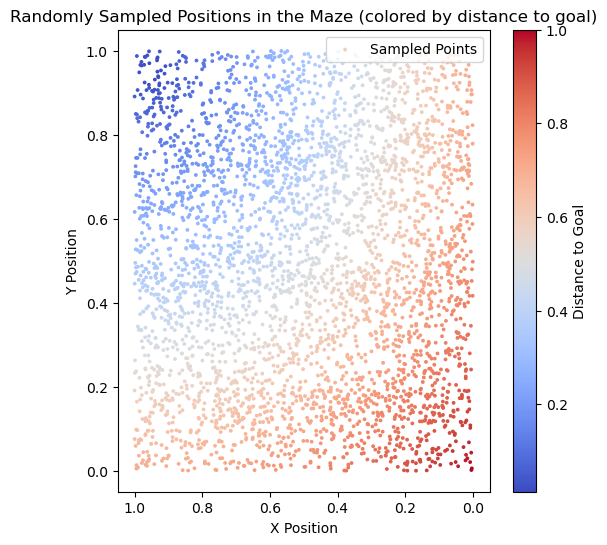

In [3]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["distance_to_goal"], cmap="coolwarm", s=3, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to goal)")
plt.colorbar(label="Distance to Goal")
plt.show()

/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_8256/322153674.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


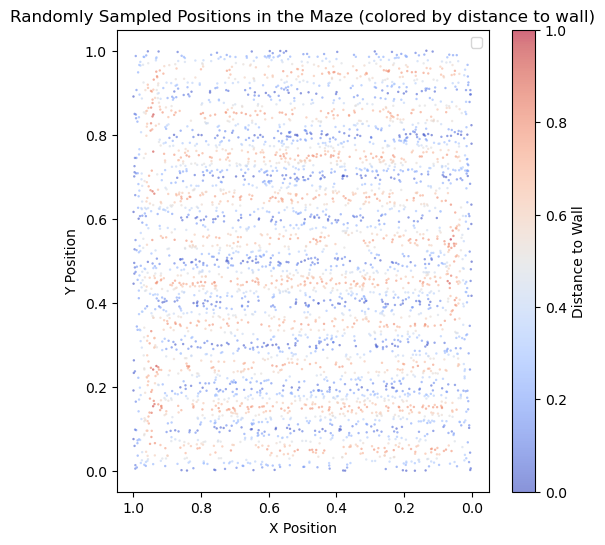

In [4]:
# Nice plot 
plt.figure(figsize=(6,6))

plt.scatter(df_positions["x"], df_positions["y"],
            c=df_positions["distance_from_wall"],
            cmap="coolwarm", s=3, linewidths=0, alpha=0.6,
            vmin=0, vmax=1)          # 0-12 cm sono quelli veramente vicini al muro

plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to wall)")
plt.colorbar(label="Distance to Wall")
plt.show()

/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_8256/603017885.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


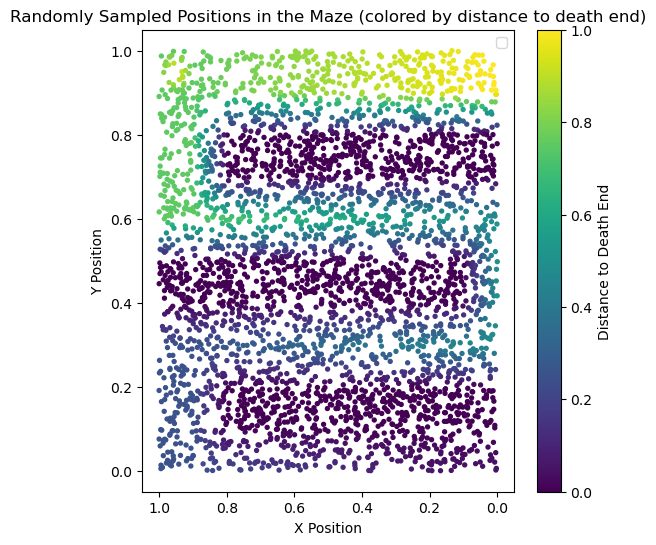

In [5]:
# Nice plot 
plt.figure(figsize=(6,6))
# plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["is_dead_end"], cmap="coolwarm", s=10, label="Sampled Points")
plt.scatter(df_positions["x"], df_positions["y"],
            c=df_positions["degree"],
            cmap="viridis", vmin=0, vmax=1, s=8)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to death end)")
plt.colorbar(label="Distance to Death End")
plt.show()

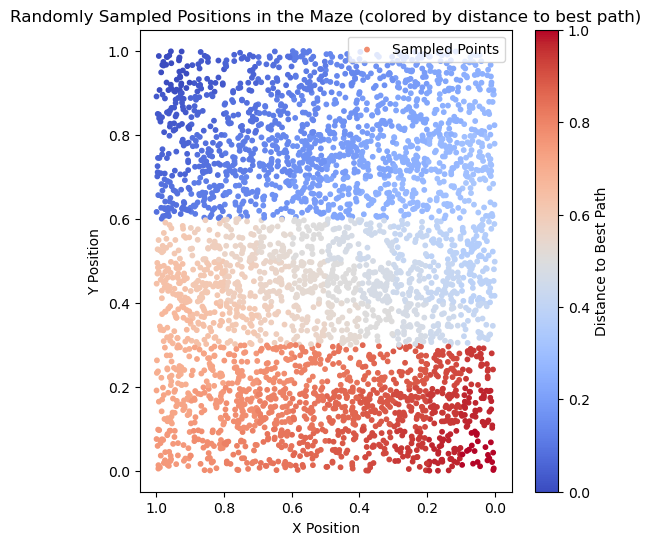

In [6]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["path_distance"], cmap="coolwarm", s=10, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to best path)")
plt.colorbar(label="Distance to Best Path")
plt.show()